# Quickstart

Let's start by download an image that we will use in this notebook

In [1]:
!wget -O test_img.jpg https://live.staticflickr.com/4418/36535618500_461f091dcd_z.jpg  >/dev/null 2>&1

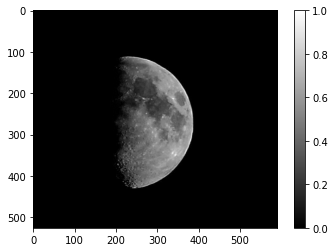

In [2]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("test_img.jpg")[...,0].astype(float)/255.
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()

# Heat equation

As an example, we will simulate the heat equation. 

$$
\frac{\partial}{\partial t}u = \nabla^2 u
$$

**NOTE** We don't enforce specific boundary conditions here: they are not yet implemented; currently, boundary conditions are implicitly defined by padding for convolutive operators in Finite Differences (which are padded with zeros), and periodic BC for Fourier discretizations. 
This is not suitable for proper integration of the heat equation, but works whenever we use some absorbing layer at the boundary: that is the majority of situations for acoustics. Clearly, a more suitable handling of generic boundary conditions would be a great addition to the package.

<br/>

We first define the domain where fields are defined. Then, the discretization family that will represent the inputs to the operator, in this case we use Finite Differences

In [3]:
from jaxdf.geometry import Domain

# Setting domain
domain = Domain(N=img.shape, dx=(1., 1.))

In [4]:
from jax import numpy as jnp
import numpy as np
from jaxdf.discretization import FiniteDifferences, OnGrid

# Define fields
params = jnp.expand_dims(jnp.asarray(img, dtype=np.float32),-1)
u = FiniteDifferences.from_grid(params, domain)

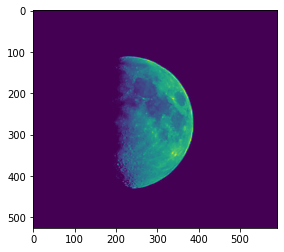

In [5]:
from matplotlib import pyplot as plt

plt.imshow(u.get_field_on_grid())

In [6]:
from jaxdf.operators.differential import laplacian
from jax import jit

u = FiniteDifferences.from_grid(params, domain)

def heat_rhs(u):
    return laplacian(u)

z = heat_rhs(u)

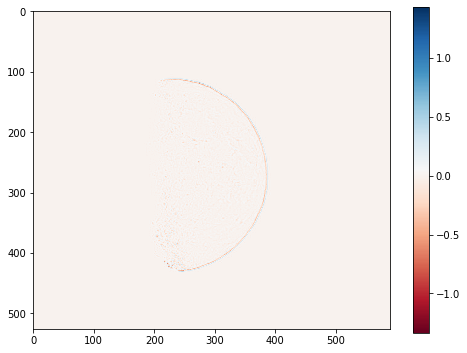

In [7]:
plt.figure(figsize=(8,6))
plt.imshow(z.get_field_on_grid(), cmap='RdBu'); plt.colorbar()

## Change discretization

Suppose we now want to use a Fourier Series discretization, rather than Finite Differences. To reuse the previously defined operator, we need to:

1. Define a new field with the new discretization
2. Call the operator
3. Extract the parameters and numerical function

In [8]:
from jaxdf.discretization import FourierSeries

u_f = FourierSeries.from_grid(params, domain)
z_f = heat_rhs(u_f)

Text(0.5, 1.0, 'Laplacian using Fourier')

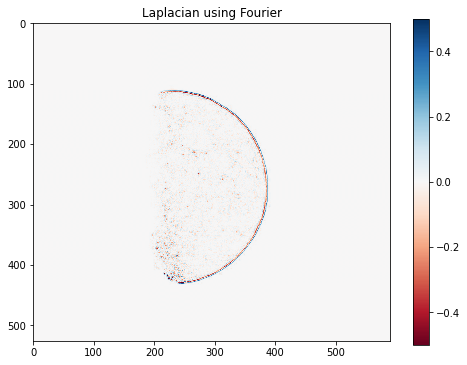

In [9]:
plt.figure(figsize=(8,6))
plt.imshow(z_f.get_field_on_grid(), cmap='RdBu', vmin=-0.5, vmax=0.5); plt.colorbar()
plt.title("Laplacian using Fourier")

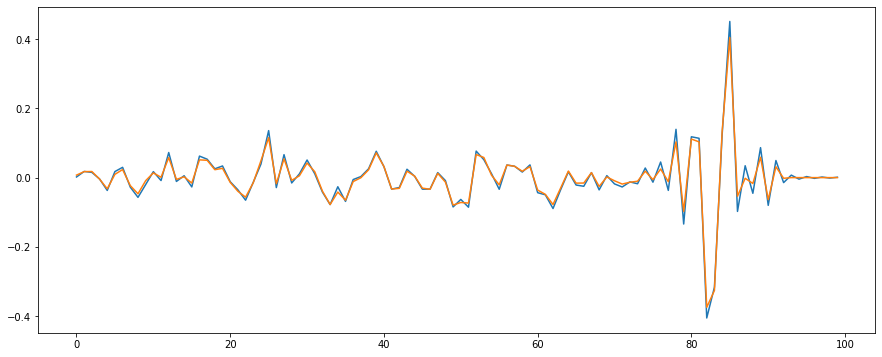

In [10]:
plt.figure(figsize=(15,6))
plt.plot(z_f.get_field_on_grid()[300,300:400])
plt.plot(z.get_field_on_grid()[300,300:400])

## Euler integration

Let's now integrate the heat equation, using a simple euler integrator. 

In [11]:
from jaxdf.ode import euler_integration

@jit
def f(u, t):
    return heat_rhs(u)

dt = 0.01
output_steps = jnp.arange(0,1001,100)

# Integrate
snapshots = euler_integration(f, u_f, dt, output_steps)
print(len(snapshots))

10


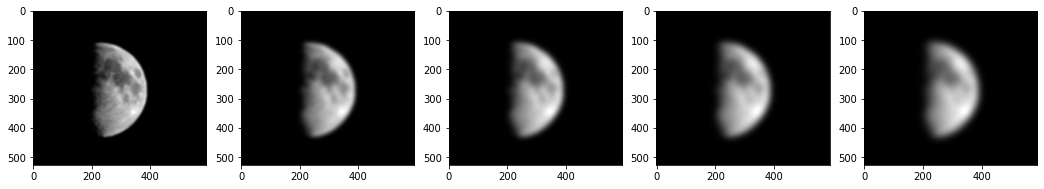

In [12]:
from jaxdf.ode import euler_integration

# Wrap function for integrator
@jit
def f(u, t):
    return heat_rhs(u)

dt = 0.1
output_steps = jnp.arange(0,1001,50)
    
# Integrate
snapshots = euler_integration(f, u_f, dt, output_steps)

# Plot
fig, axes = plt.subplots(1, 5, figsize=(18,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*4].get_field_on_grid(), cmap="gray")

Let's wrap it all up into a constructor. This funcion accepts a discretization, such that by changing the input we can construct different numerical simulators of the same equation

In [13]:
def make_simulator(
    discretization
):
    # Simulation parameters
    dt = 0.1
    output_steps = jnp.arange(0,1001,50)

    # Initialize field
    u0 = discretization.from_grid(params, domain)
    
    def f(u, t):
        return heat_rhs(u)
    
    @jit
    def simulate(u0):
        return euler_integration(f, u0, dt, output_steps)
    
    return u0, simulate

In [14]:
u0, simulate = make_simulator(FourierSeries)

In [15]:
snapshots = simulate(u0)

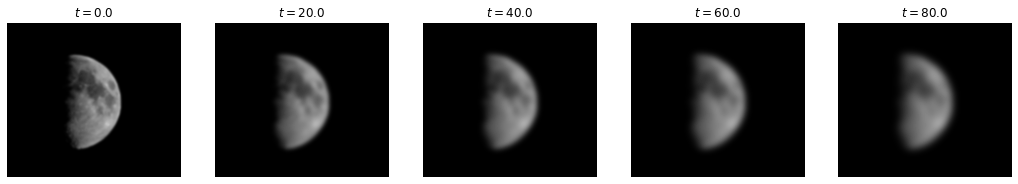

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(18,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*4].get_field_on_grid(), vmin=0, vmax=1., cmap="gray")
    axes[i].axis('off')
    axes[i].set_title(f"$t={str(output_steps[4*i]*dt)}$")
    
plt.savefig("diffusion_example.png")

In [17]:
u0, simulate = make_simulator(FiniteDifferences)
snapshots = simulate(u0)

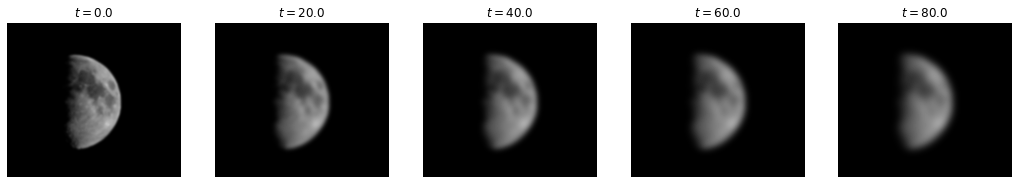

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(18,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*4].get_field_on_grid(), vmin=0, vmax=1., cmap="gray")
    axes[i].axis('off')
    axes[i].set_title(f"$t={str(output_steps[4*i]*dt)}$")
    
plt.savefig("diffusion_example.png")

### Timings

Heat equation for 1000 steps using 2nd order accurate Finite Differences, on a 256x256 domain

In [19]:
!nvidia-smi | head -n 10

Sun Jan 23 23:48:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   59C    P0    35W / 125W |   7743MiB /  7973MiB |      0%      Default |


Heat equation for 1000 steps using Fourier spectral methods

In [25]:
u0, simulate = make_simulator(FourierSeries)
snapshots = simulate(u0)

In [26]:
%%timeit
snapshots = simulate(u0)[-1].params.block_until_ready()

239 ms ± 679 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Heat equation for 1000 steps using 4th order accurate central differences

In [27]:
u0, simulate = make_simulator(FiniteDifferences)
snapshots = simulate(u0)

In [28]:
%%timeit
snapshots = simulate(u0)[-1].params.block_until_ready()

106 ms ± 677 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## More complex operators

We can of course construct more complex operators than the heat equation, using composition

In [29]:
from jaxdf.operators.functions import compose

def heat_rhs(u):
    L = laplacian(u)
    q = compose(u)(lambda x: jnp.sin(2*jnp.pi*(x+0.25)))
    p = compose(u**2)(lambda x: jnp.where(x>0, x, 0.))
    return L - 0.001*q + 0.01*p

In [30]:
u0, simulate = make_simulator(FiniteDifferences)

In [31]:
snapshots = simulate(u0)

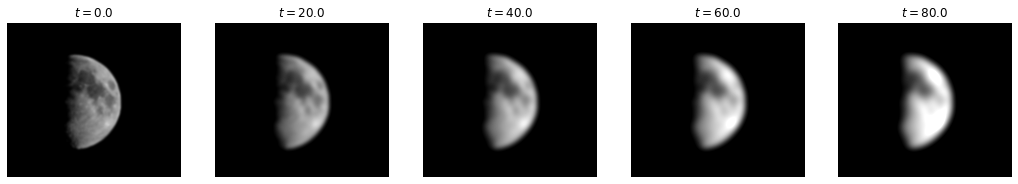

In [32]:
fig, axes = plt.subplots(1, 5, figsize=(18,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*4].get_field_on_grid(), vmin=0, vmax=1., cmap="gray")
    axes[i].axis('off')
    axes[i].set_title(f"$t={str(output_steps[4*i]*dt)}$")
    
plt.savefig("diffusion_example.png")